# BASIC #

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

import dqn
from dqn import ReplayMemory, DQN

import plot_dqn as plot

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#function for saving trained models in a folder
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [ ]:
#autoreload modified modules
%load_ext autoreload
%autoreload 2

# DATA PIPELINE #

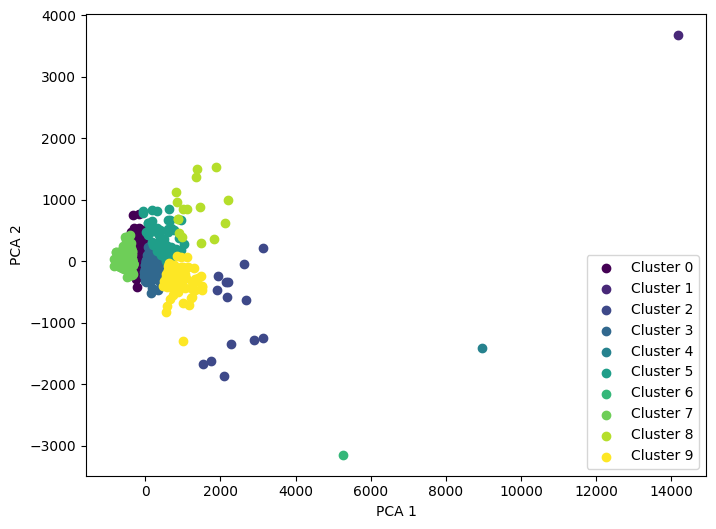

In [ ]:
'''
Data pipeline:
    - Read filtered stocks closing prices as CSV/in SQL
    - Find clusters with kmeans and PCA
    - Filter out some outlier clusters; key clusters # as a dict
    - Find cointegration of each key cluster and plot heatmap
'''
import data_pipeline as pipeline

random_state = 42
n_clusters = 10

#if downloading from data pipeline
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(), )

#if read dailyDF from saved Excel file
#dailyDF = pd.read_excel('./data/dailyDF_230408.xlsx', header=0, index_col=0, skiprows=0, parse_dates=True)

dailyDF.index = pd.to_datetime(dailyDF.index)

clusters = pipeline.findStockClusters(dailyDF, n_clusters)
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)
pipeline.plotStockClusters(clusters)

In [ ]:
#if need to save dailyDF as an Excel
'''
dailyDFcopy = dailyDF.copy()
dailyDFcopy.index = dailyDFcopy.index.tz_convert(None)
dailyDFcopy.to_excel('./data/dailyDF_230408.xlsx')
'''

In [ ]:
#just to check how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 344 stocks
cluster 2: 14 stocks
cluster 3: 236 stocks
cluster 5: 66 stocks
cluster 7: 338 stocks
cluster 8: 16 stocks
cluster 9: 75 stocks


[('SLRC', 'BKSC'), ('FVCB', 'ARKR'), ('GDYN', 'SHBI'), ('GDYN', 'AMBC'), ('GDYN', 'CCRN'), ('GDYN', 'ARKR'), ('GDYN', 'PROV'), ('GDYN', 'NFBK'), ('GHY', 'NODK'), ('SMLR', 'GPP'), ('SMLR', 'MUA'), ('SMLR', 'SHBI'), ('SMLR', 'NTIC'), ('SMLR', 'VLT'), ('SMLR', 'FIF'), ('SMLR', 'BANX'), ('SMLR', 'AMBC'), ('SMLR', 'BKSC'), ('SMLR', 'NXGN'), ('SMLR', 'EOI'), ('SMLR', 'MYD'), ('SMLR', 'THQ'), ('SMLR', 'CCRN'), ('SMLR', 'ARKR'), ('SMLR', 'RUTH'), ('SMLR', 'MRUS'), ('SMLR', 'TPVG'), ('SMLR', 'PROV'), ('SMLR', 'NFBK'), ('SMLR', 'JHI'), ('SMLR', 'EBMT'), ('SMLR', 'HONE'), ('SMLR', 'JHS'), ('SMLR', 'UBA'), ('GPP', 'CCRN'), ('MCI', 'AMBC'), ('MCI', 'PROV'), ('VLT', 'NODK'), ('FIF', 'CCRN'), ('FIF', 'ARKR'), ('FIF', 'NFBK'), ('AMBC', 'BKSC'), ('AMBC', 'PROV'), ('BKSC', 'MRUS'), ('THQ', 'NODK'), ('THQ', 'JHS'), ('CCRN', 'ARKR'), ('ARKR', 'NFBK'), ('MRUS', 'NODK'), ('MRUS', 'EBMT'), ('NODK', 'TPVG'), ('NODK', 'JHI'), ('PROV', 'UBA')]


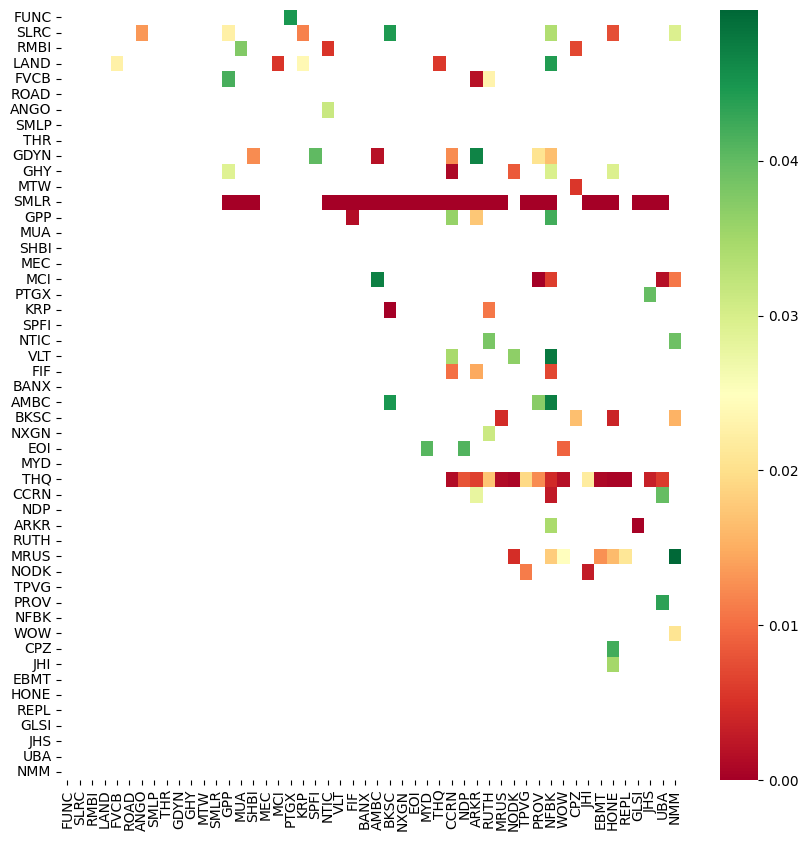

In [ ]:
#split train/test data by time: 70/30#
#manually choose cluster of a reasonable size (80-100 stocks) AND REASONABLY DISPERSED for training model
dailyDF_train = dailyDF[good_clusters_dict[0]]

train_startdate = dailyDF_train.index[0]
train_enddate = train_startdate + pd.DateOffset(years=5)
trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF_train.loc[train_startdate:train_enddate].dropna(axis=1, how='all'), 
                                                       random_state)

In [ ]:
#create trainenvs
window_size = 60
#trade_period = 5
transaction_cost = 0.05

trainenvs = []
for trainpair in trainpairs:
    traindata = traindf[list(trainpair)].dropna()
    if traindata.shape[0] > 450:
        trainenvs.append(StockTradingEnvironment(traindata.copy(), window_size, transaction_cost))   #instantiate an env; automatatically run trade()


In [ ]:
print(f'The no. of trainpairs and trainevns are respectively {len(trainpairs)} and {len(trainenvs)}.')

The no. of trainpairs and trainevns are respectively 53 and 53.


[('FIF', 'UNTY'), ('FIF', 'SAMG'), ('MLYS', 'DWACU'), ('MLYS', 'VTOL'), ('UBA', 'PINE'), ('DWACU', 'NEWT'), ('DWACU', 'LAKE'), ('NTIC', 'HQL'), ('NTIC', 'GDO'), ('NTIC', 'IDYA'), ('BGX', 'JHI'), ('VTOL', 'REFI'), ('HQL', 'GDO'), ('HQL', 'WILC'), ('NEWT', 'JRI'), ('BGH', 'SLRC'), ('PINE', 'HMNF'), ('CAMT', 'CSWC'), ('CAMT', 'HPS'), ('CSWC', 'REFI'), ('CSWC', 'HPS'), ('NAPA', 'HPS'), ('DIAX', 'THQ'), ('MUJ', 'RIV'), ('REFI', 'WILC'), ('GDO', 'WILC'), ('GDO', 'GHY'), ('NPV', 'WILC'), ('WILC', 'GHY'), ('WILC', 'RIV'), ('WILC', 'JHI'), ('GHY', 'JHI')]


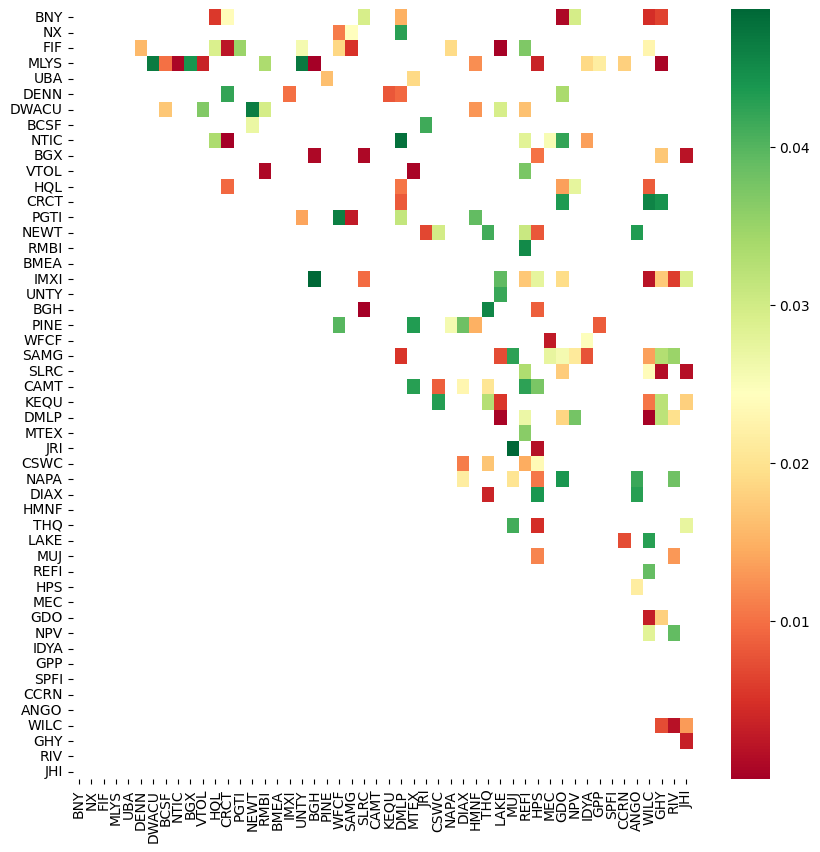

In [ ]:
#val set heatmap
valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF_train.loc[train_enddate:].dropna(axis=1, how='all'), 
                                                 random_state=random_state)

In [ ]:
#create valenvs
valenvs = []
for valpair in valpairs:
    valdata = valdf[list(valpair)].dropna()
    if valdata.shape[0] > 250:
        valenvs.append(StockTradingEnvironment(valdata.copy(), window_size, transaction_cost))   #instantiate an env; automatatically run trade()

In [ ]:
print(f'The no. of validation pairs and validation evns are respectively {len(valpairs)} and {len(valenvs)}.')

The no. of validation pairs and validation evns are respectively 32 and 30.


# DEEP Q-NETWORK #

In [ ]:
#Code credit: https://github.com/jeffreyyu0602/ZheShang/tree/0cebb2ec90a5921d06a4d117e9202cca1ae511fc
#With modifications

BATCH_SIZE = 256   #increased fom 128
GAMMA = 0.95          #decreased from 0.999
EPS_START = 0.9
EPS_END = 0.02   #decreased from 0.05
EPS_DECAY = 2000  #increased from 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions, device).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions, device).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-6)   #from torch.optim; RMSprop = optimizer like SGD or Adam; lr decreased from 1e-4
memory = ReplayMemory(127000)   #increased from 10000

In [ ]:
#training agent
num_episodes = 80
best_rewards = 0
steps_done = 0

#empty dicts to collect train/test rewards/returns
train_reward_dict = {}
train_return_dict = {}
val_reward_dict = {}
val_return_dict = {}


for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []

    #initialize train_reward_dict and train_return_dict for this
    train_reward_dict[i_episode] = []
    train_return_dict[i_episode] = []
    val_reward_dict[i_episode] = []
    val_return_dict[i_episode] = []

    #initialize nn_counter for this episode
    nn_counter = 0
    
    for trainenv in trainenvs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = trainenv.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        
        for t in count():   #keep looping until done -> break
            # Select and perform an action and return whether this action is returned by policy_network
            action, nn_count = policy_net.select_action(state, EPS_START, EPS_END, EPS_DECAY, steps_done, policy_net, n_actions)   #epsilon-greedy: exploit or explore; state is this state
            #obs, reward, done, info = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            obs, step_reward, done, info, step_return = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            #append reward and return of this episode in the list
            train_reward_dict[i_episode].append(step_reward)
            train_return_dict[i_episode].append(step_return)
            
            step_reward = torch.tensor([step_reward], dtype=torch.float, device=device)
            step_return = torch.tensor([step_return], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each state means 60 past zscores + current action + pvalue
            #each memory pushes 62 + 62 + 3 = 127 
            memory.push(state, action, next_state, step_reward)

            # Move to the next state
            state = next_state

            #tick steps_done to trigger epsilon-greedy
            steps_done += 1
            nn_counter += nn_count

            #new
            #train_rewards.append(reward)

            # Perform one step of the optimization (on the policy network)
            policy_net.optimize_model(memory, BATCH_SIZE, policy_net, target_net, GAMMA, optimizer)   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    val_rewards = []
    val_returns = []
    with torch.no_grad():
        for valenv in valenvs:
            
            obs = valenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, step_reward, done, info, step_return = valenv.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                #append reward and return of this episode in the list
                val_reward_dict[i_episode].append(step_reward)
                val_return_dict[i_episode].append(step_return)

                if done:
                    val_rewards.append(info['total_reward'])
                    val_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(val_rewards)
    if (avg_rewards > best_rewards) and (i_episode != 0):   #disregarding the 1st model because the 1st model often has highest score and it's useless to save
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}, policy_nn_actions:{}, training steps:{}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(val_rewards),
           np.mean(val_returns), nn_counter, len(train_reward_dict[i_episode])))

print('Complete')

epoch [1/80], train rewards:-5.1088, returns:-3.2130, val rewards:2.0431, returns:2.0960, policy_nn_actions:75603, training steps:78996
epoch [2/80], train rewards:-6.7747, returns:-5.1168, val rewards:0.8145, returns:0.8672, policy_nn_actions:77442, training steps:78996
epoch [3/80], train rewards:-5.2726, returns:-3.6267, val rewards:0.2402, returns:0.3005, policy_nn_actions:77470, training steps:78996
epoch [4/80], train rewards:-5.6196, returns:-4.0191, val rewards:0.4638, returns:0.5158, policy_nn_actions:77413, training steps:78996
epoch [5/80], train rewards:-6.9058, returns:-5.2939, val rewards:-1.1964, returns:-1.1286, policy_nn_actions:77333, training steps:78996
epoch [6/80], train rewards:-7.3047, returns:-5.3794, val rewards:0.3495, returns:0.4315, policy_nn_actions:77307, training steps:78996
epoch [7/80], train rewards:-5.3153, returns:-3.6131, val rewards:0.3990, returns:0.4915, policy_nn_actions:77360, training steps:78996
epoch [8/80], train rewards:-5.5994, returns:-

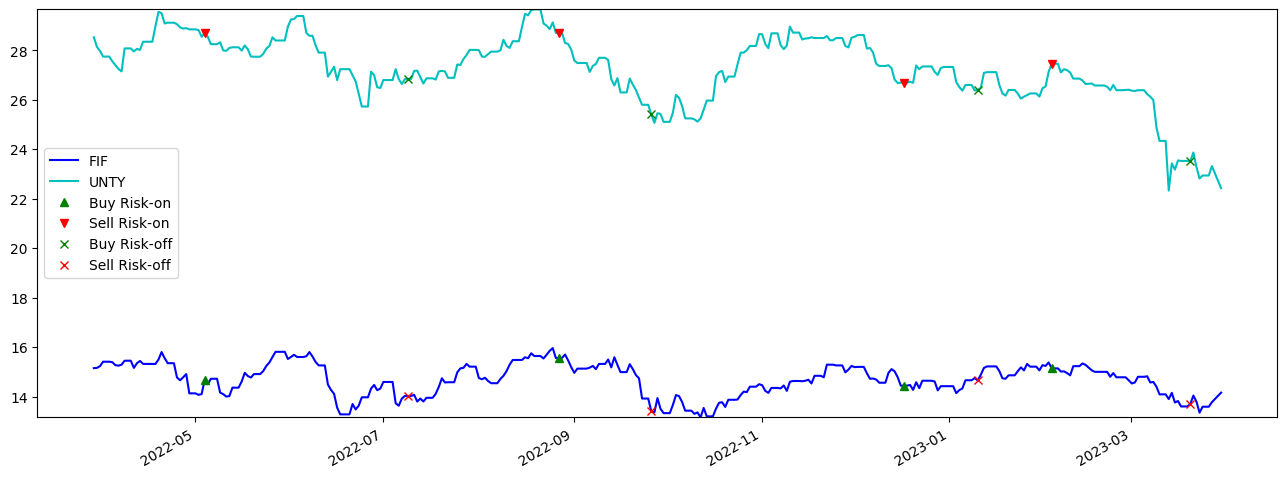

Total reward for this pair: 1.3651345034909532
Total return for this pair: 1.416301440218401


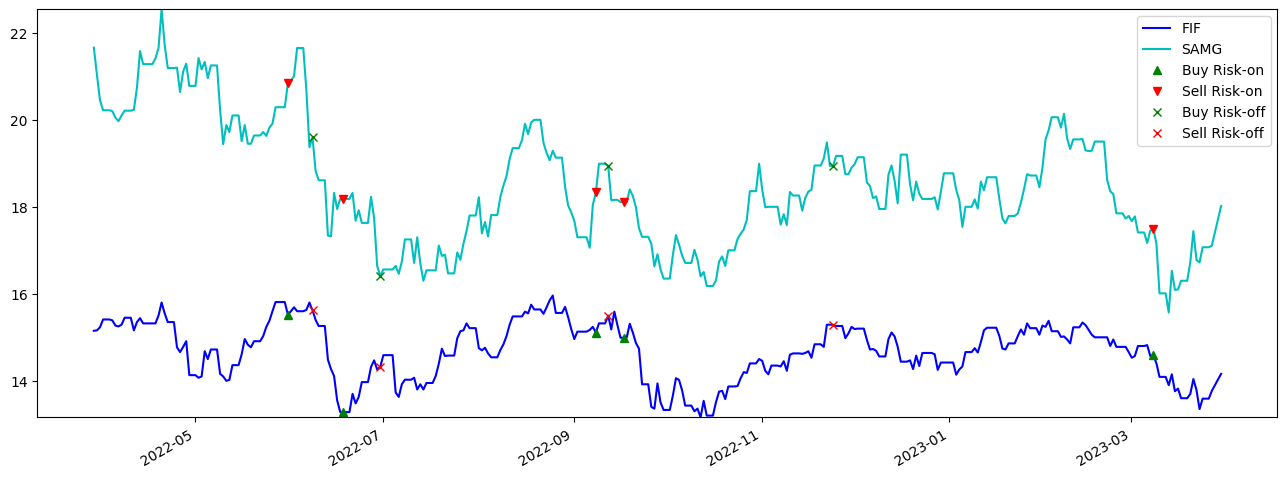

Total reward for this pair: -0.03451297297815259
Total return for this pair: -0.01958580209007421


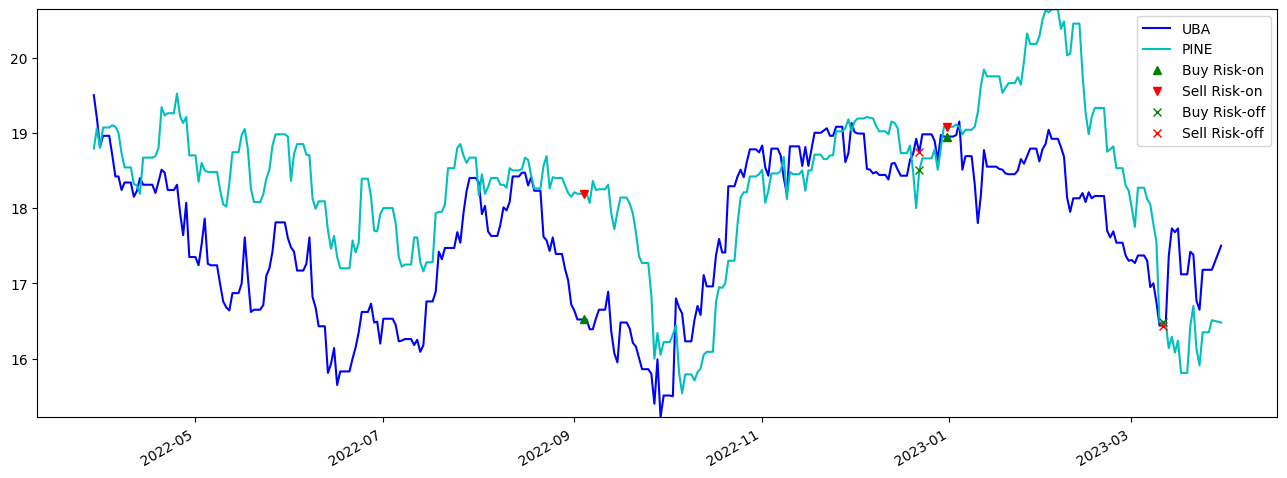

Total reward for this pair: 6.036999428840234
Total return for this pair: 6.121974817071348


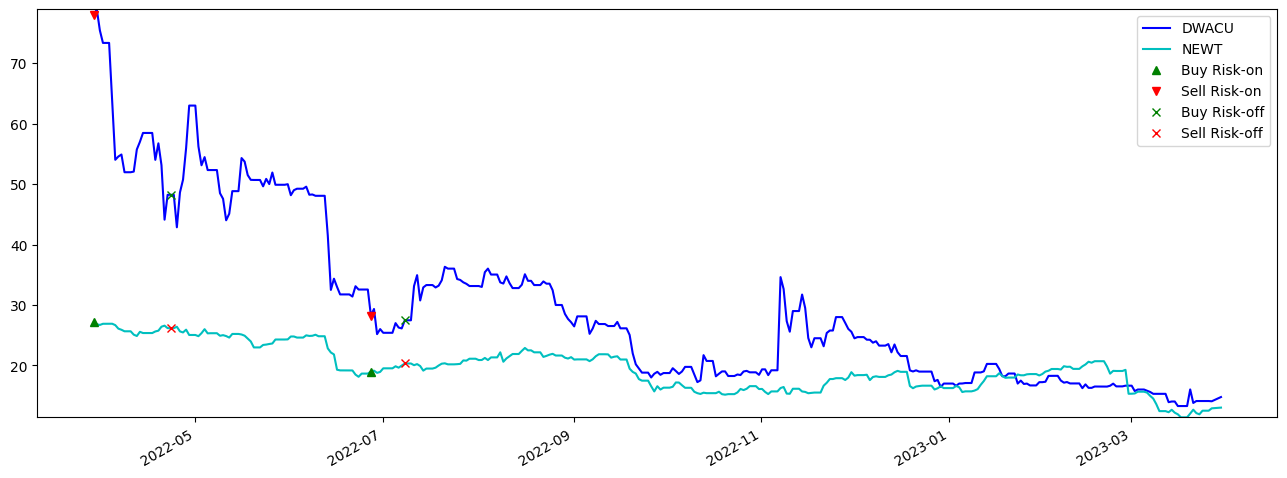

Total reward for this pair: 12.3644864929514
Total return for this pair: 12.3644864929514


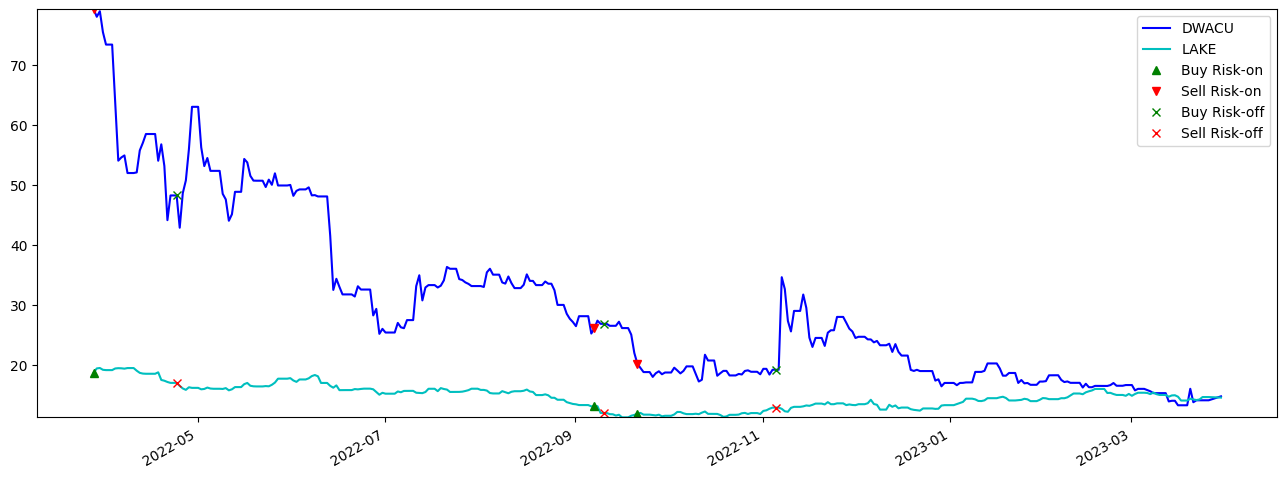

Total reward for this pair: 43.89491552061894
Total return for this pair: 44.078296163086435


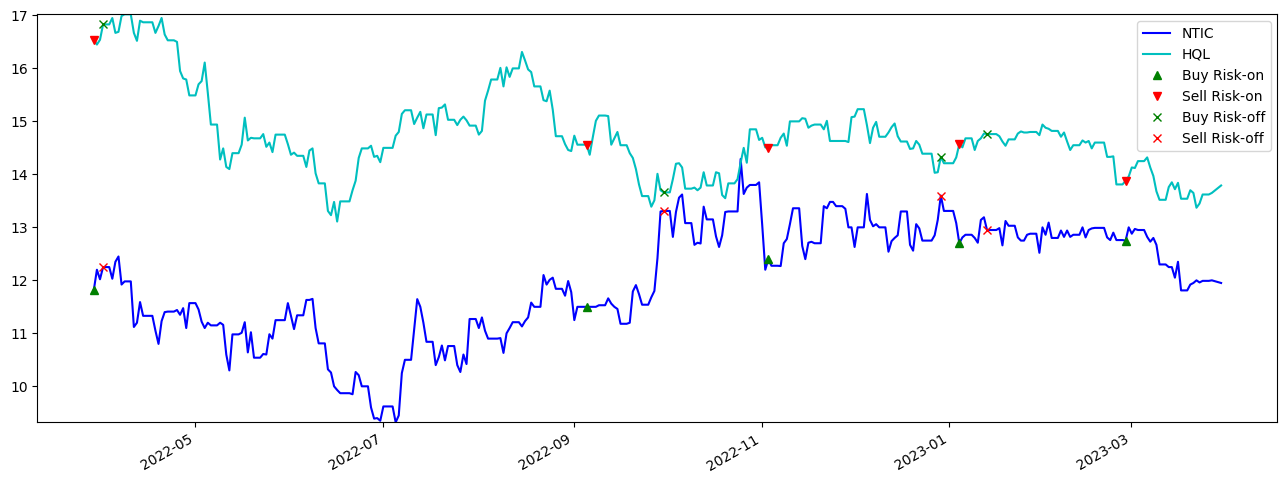

Total reward for this pair: 3.795290155470771
Total return for this pair: 3.795290155470771


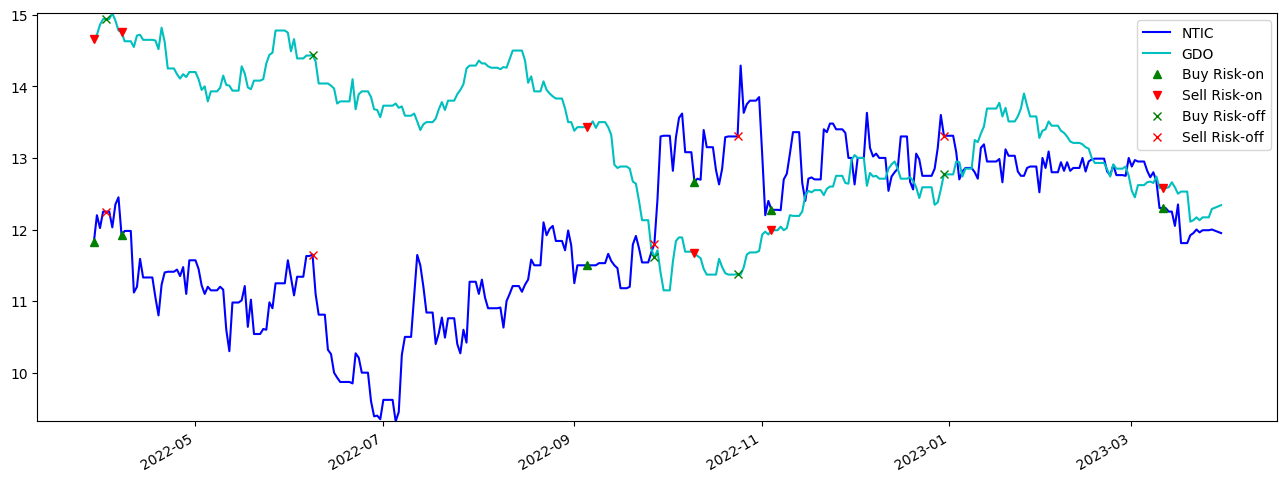

Total reward for this pair: 3.5489899951868535
Total return for this pair: 3.5940879640954027


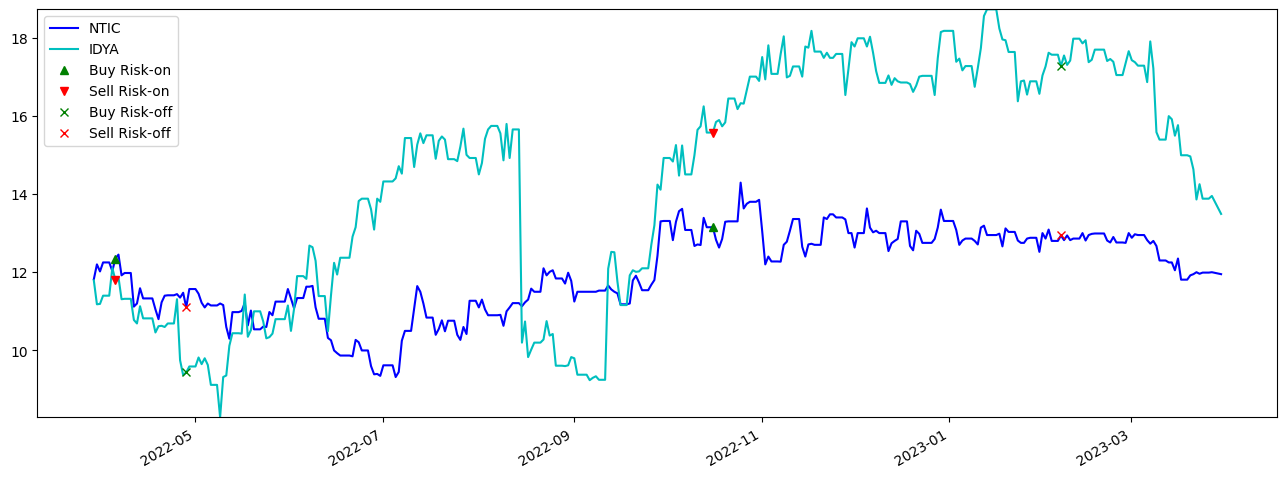

Total reward for this pair: 0.7542183500514537
Total return for this pair: 0.7542183500514537


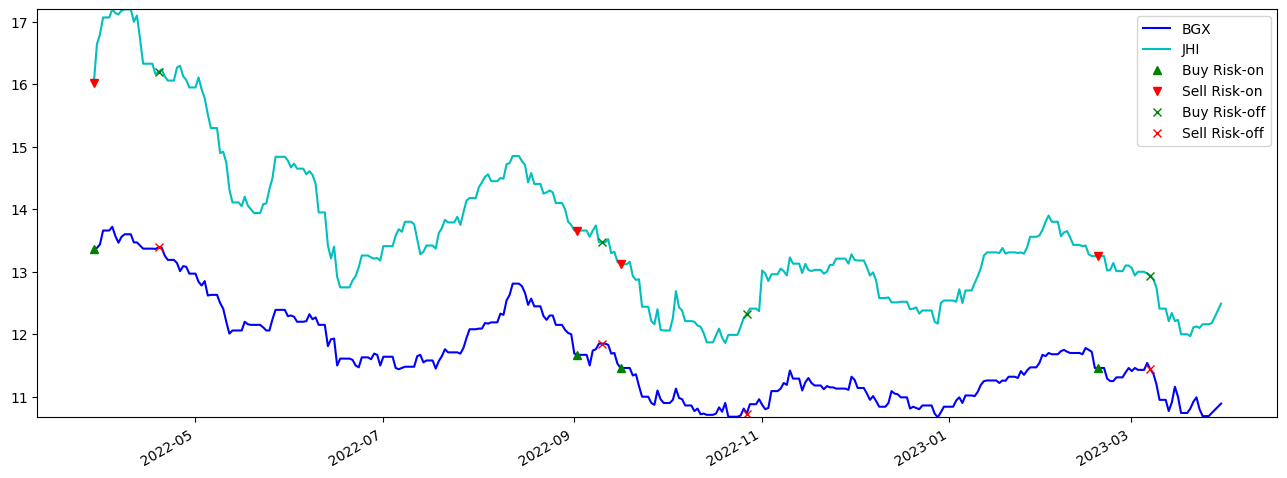

Total reward for this pair: 0.0432674715370191
Total return for this pair: 0.0432674715370191


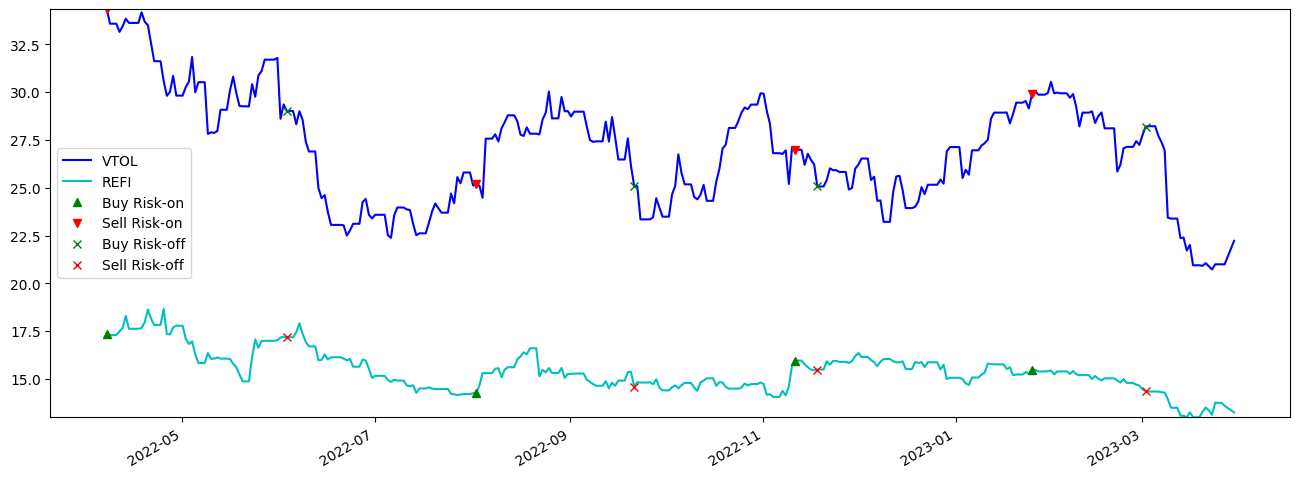

Total reward for this pair: 6.295510836323746
Total return for this pair: 6.295510836323746


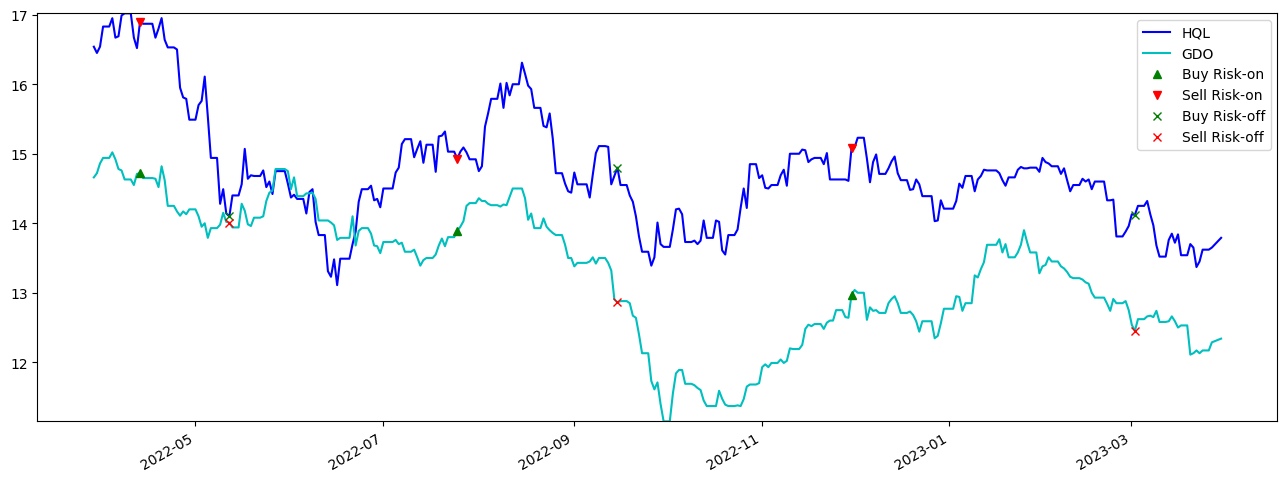

Total reward for this pair: 2.402244667625543
Total return for this pair: 2.402244667625543


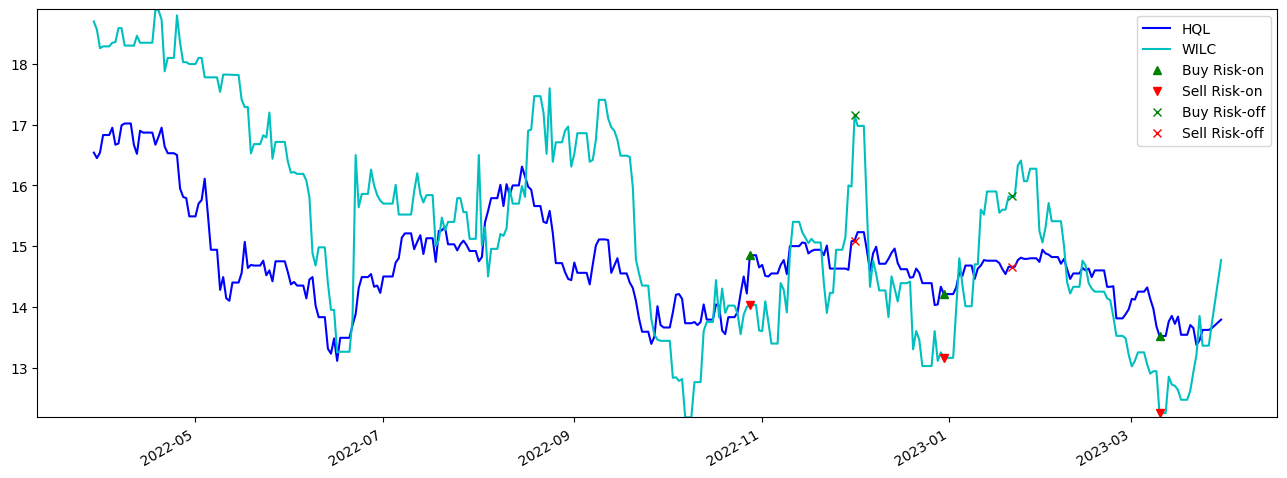

Total reward for this pair: -2.5580283453603045
Total return for this pair: -2.5580283453603045


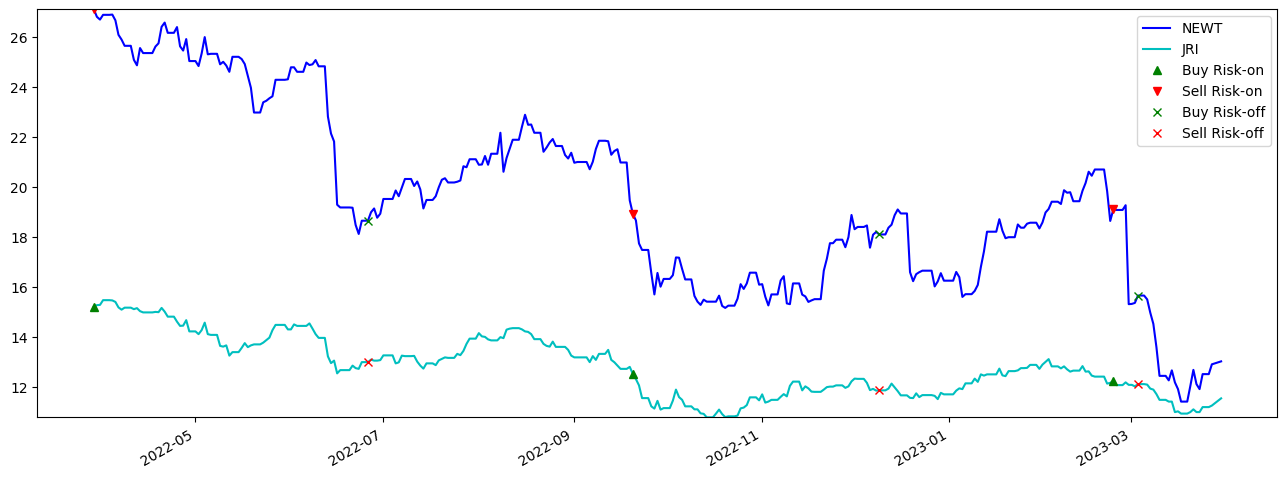

Total reward for this pair: 8.14346705014485
Total return for this pair: 8.14346705014485


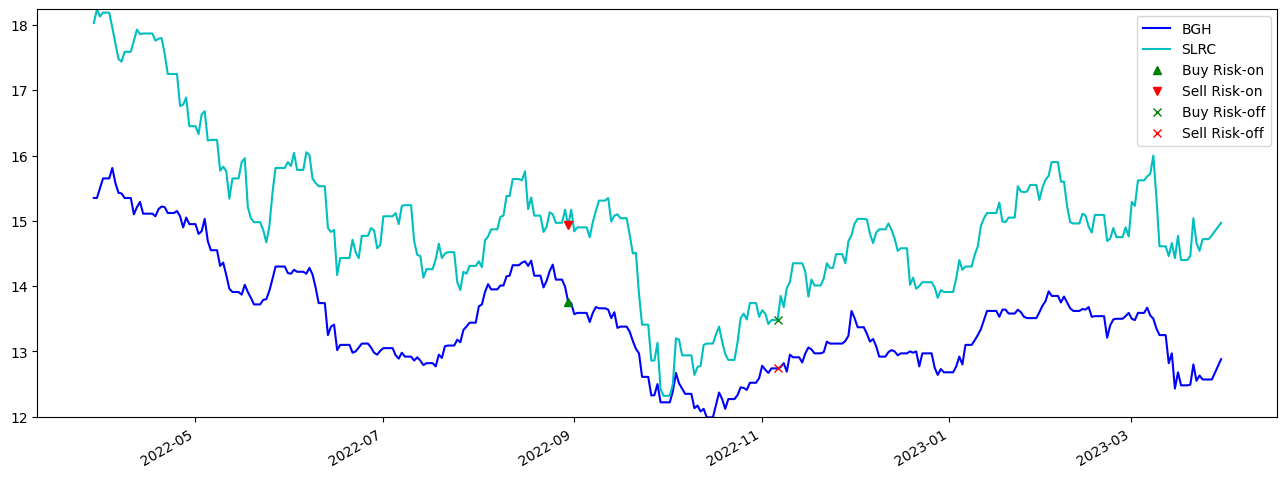

Total reward for this pair: -0.70976584769579
Total return for this pair: -0.6305863857989487


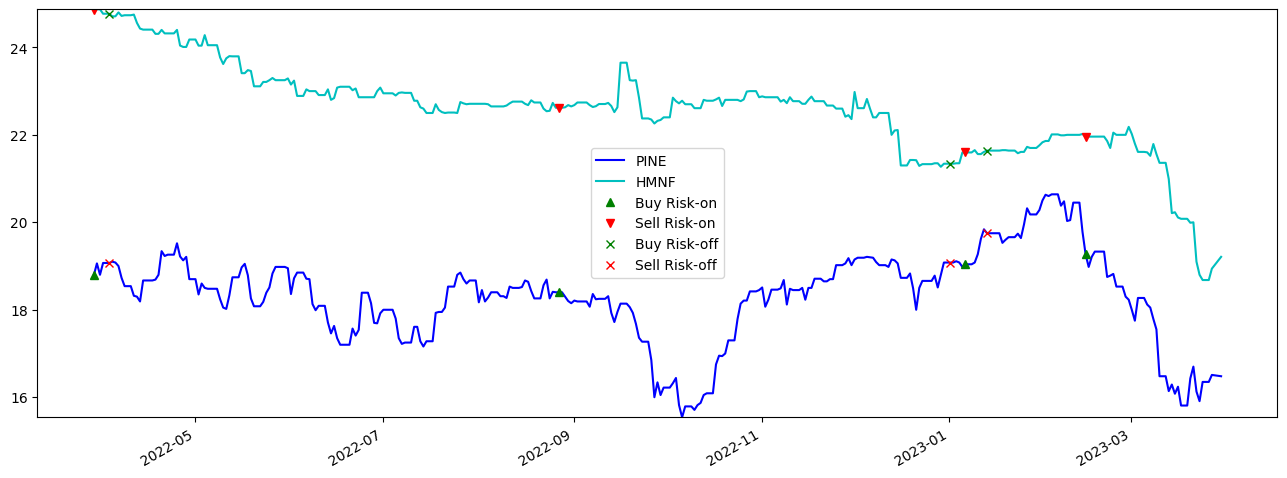

Total reward for this pair: 4.075532716441122
Total return for this pair: 4.261368616694939


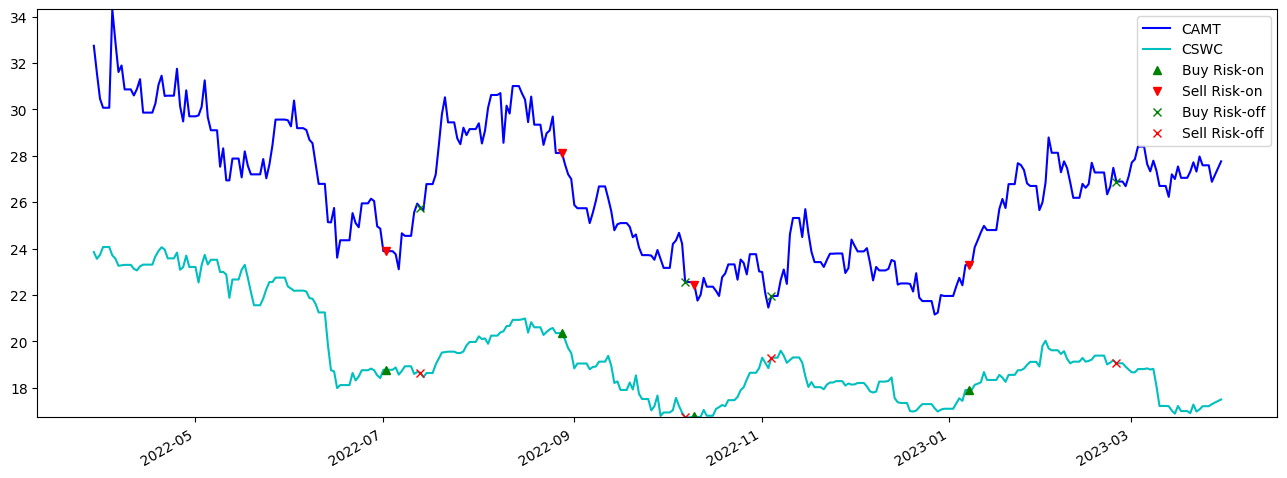

Total reward for this pair: 5.892925651492624
Total return for this pair: 6.213046374406887


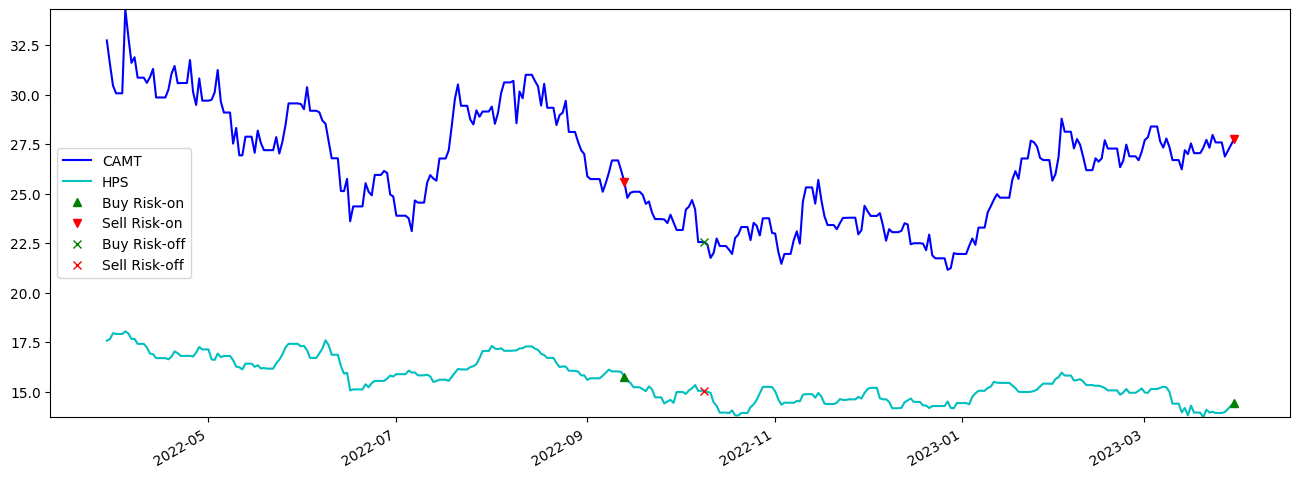

Total reward for this pair: -8.154510692563932
Total return for this pair: -7.840070040236415


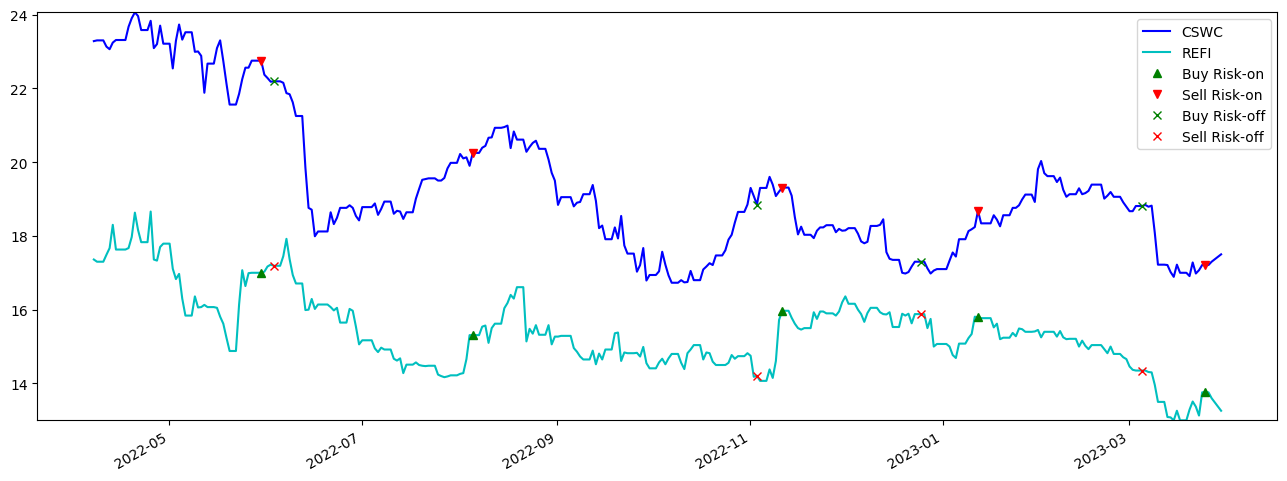

Total reward for this pair: 0.4568790558449134
Total return for this pair: 0.49462539141114004


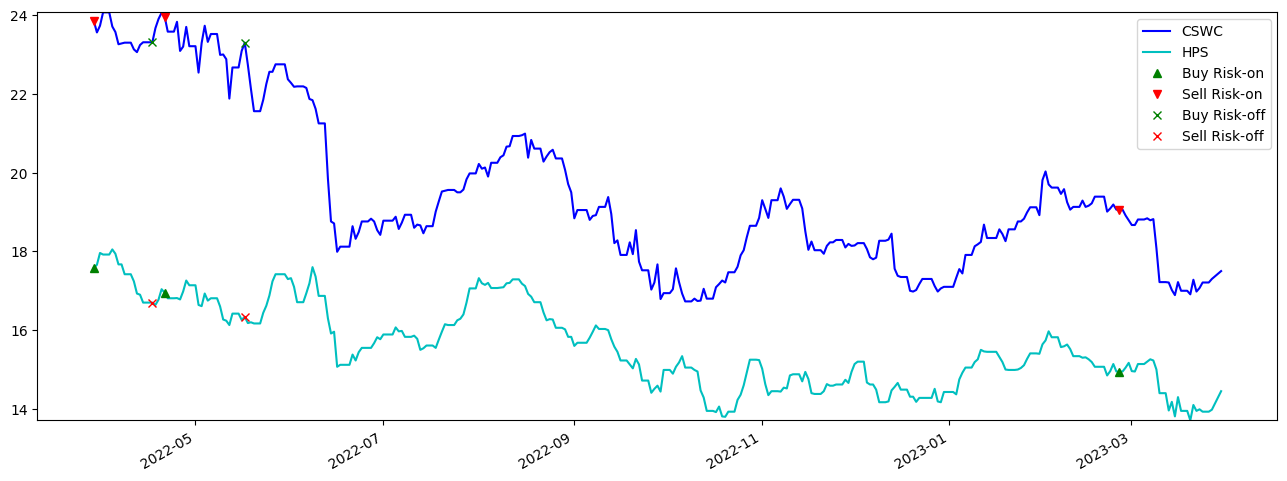

Total reward for this pair: -4.943665642012868
Total return for this pair: -4.8315042903942444


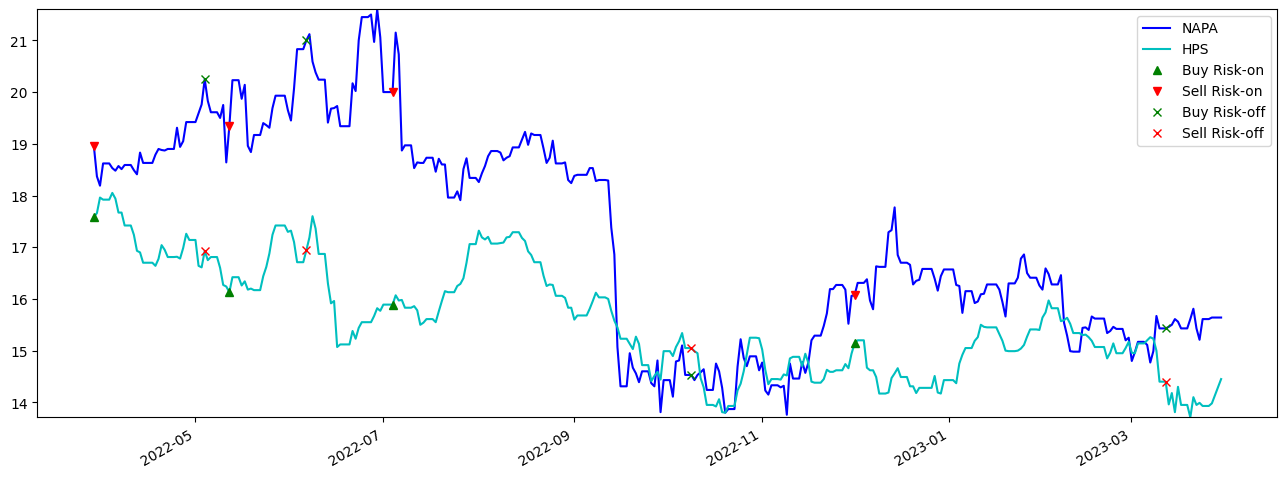

Total reward for this pair: 7.342563944970114
Total return for this pair: 7.342563944970114


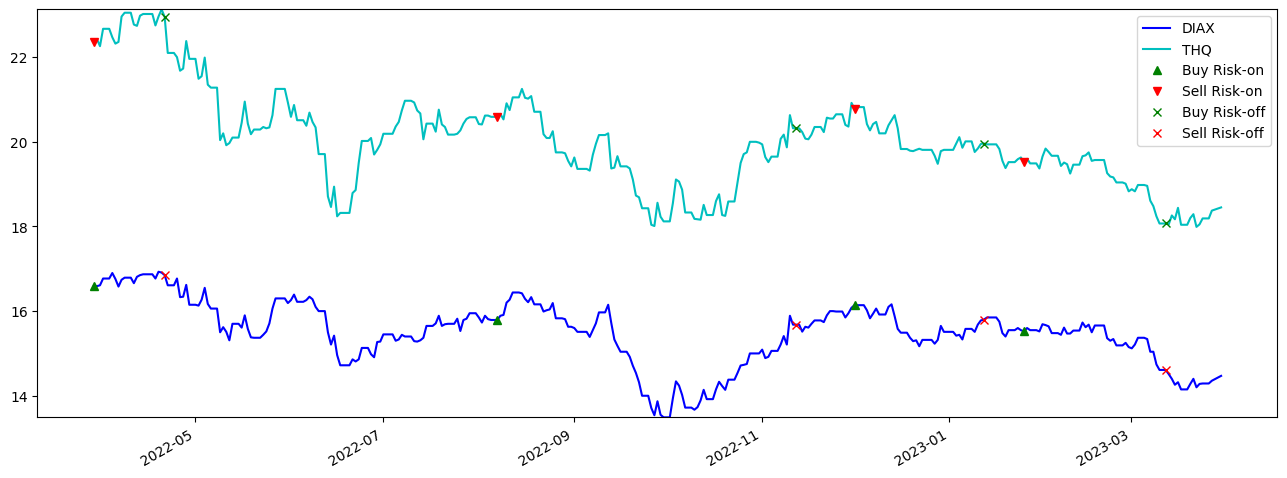

Total reward for this pair: -0.7546094902508789
Total return for this pair: -0.7546094902508789


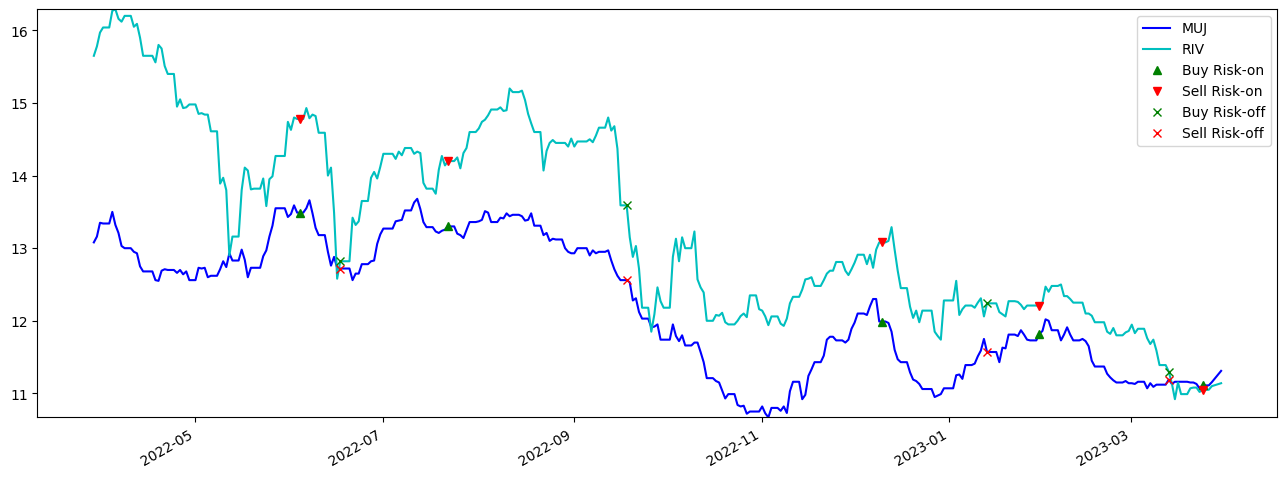

Total reward for this pair: 1.3849212339646495
Total return for this pair: 1.4489298436278706


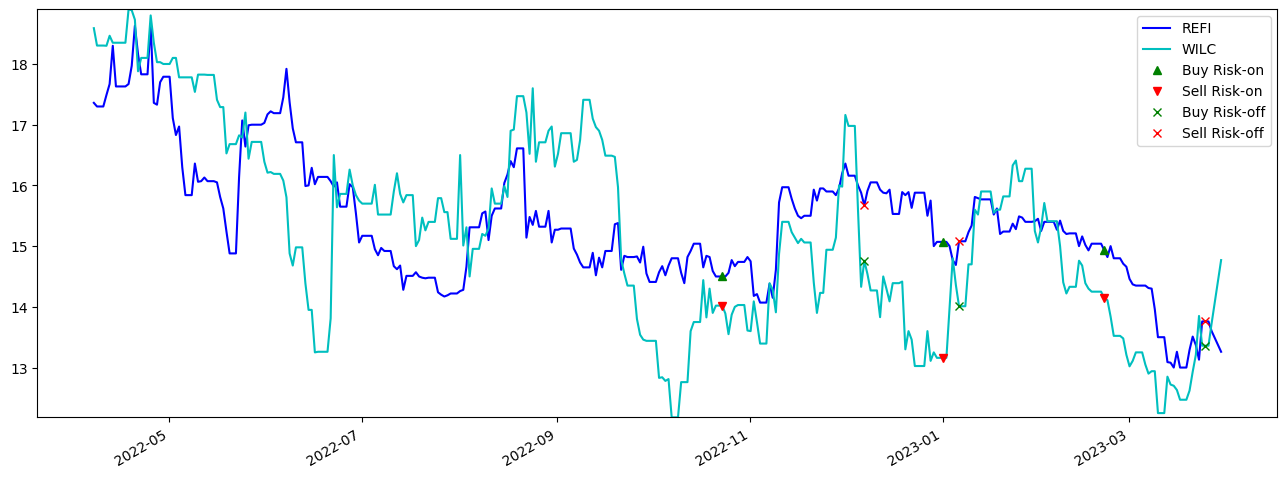

Total reward for this pair: -0.980597013876533
Total return for this pair: -0.9367950280804355


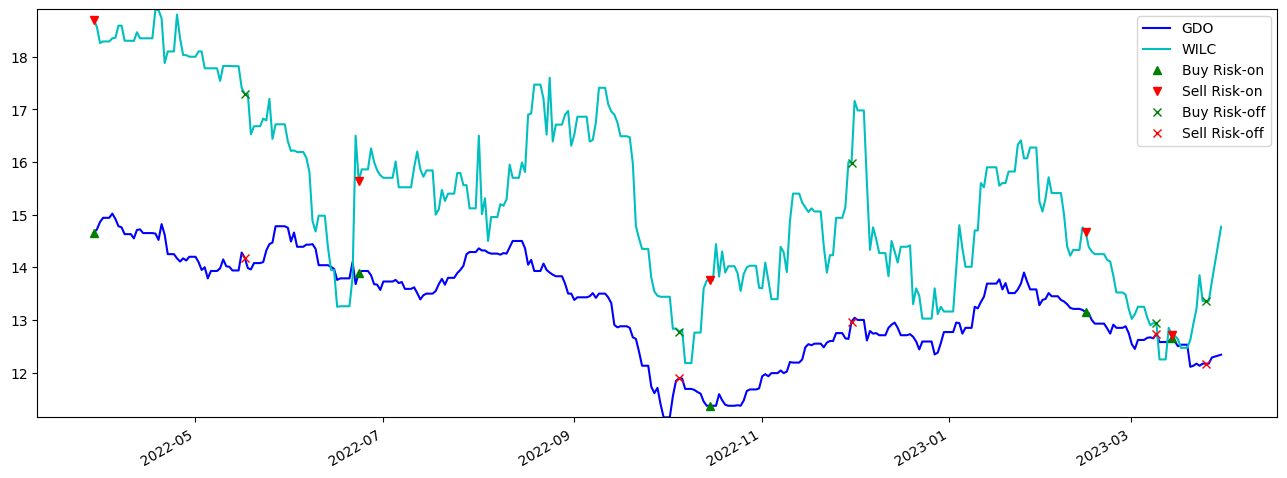

Total reward for this pair: 2.223410263372501
Total return for this pair: 2.2729313280628025


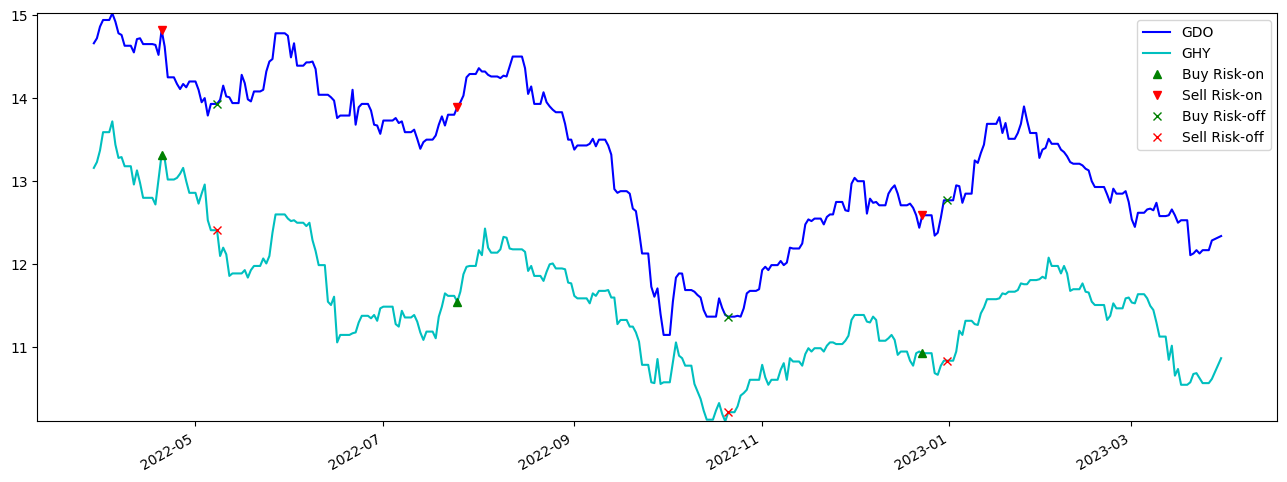

Total reward for this pair: 0.46974798282982916
Total return for this pair: 0.46974798282982916


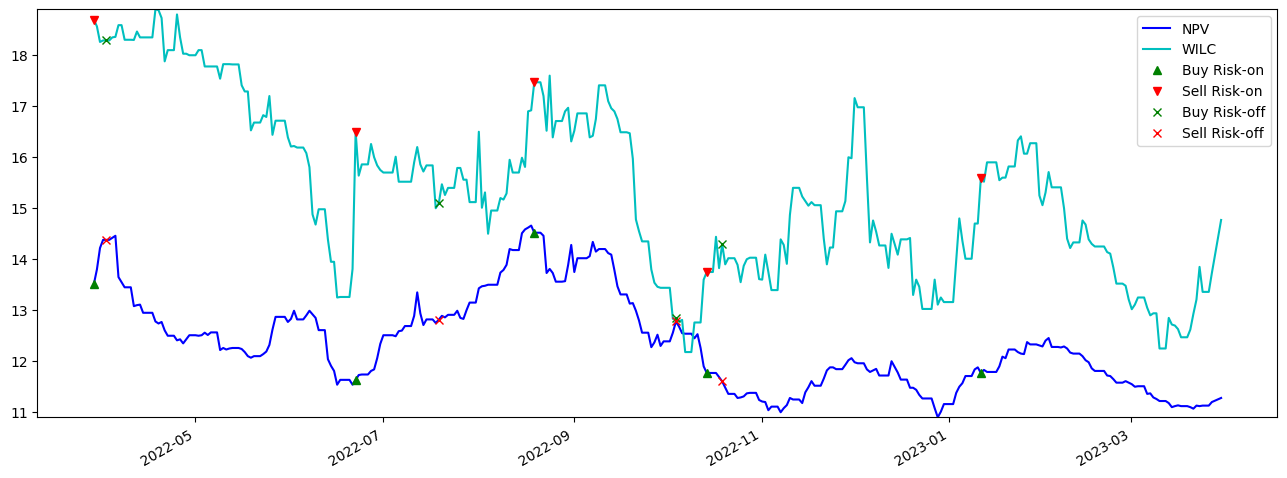

Total reward for this pair: 1.4722556923306647
Total return for this pair: 1.56275887783213


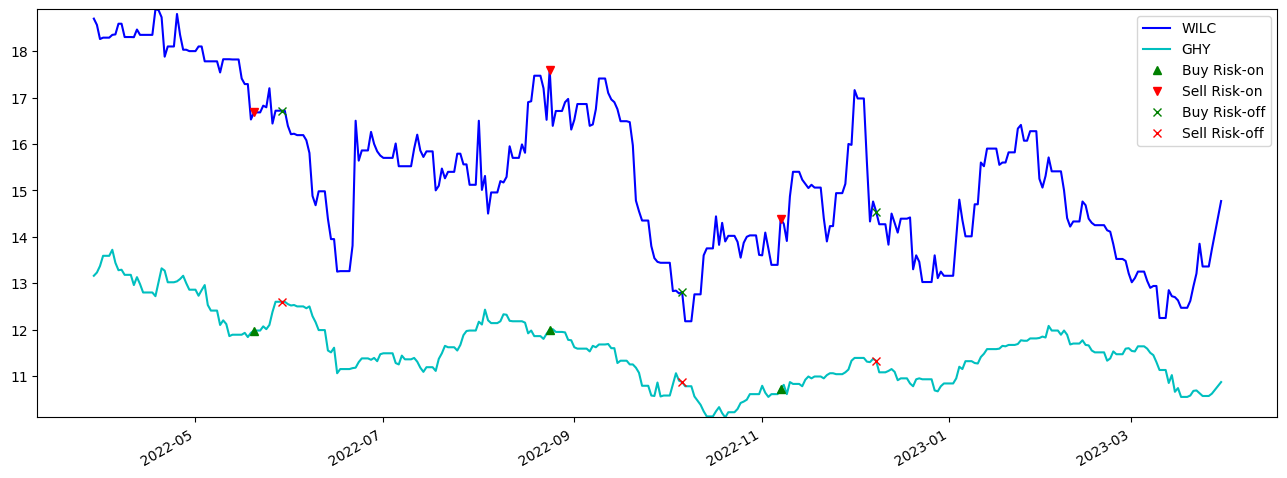

Total reward for this pair: 7.5197913922370905
Total return for this pair: 7.5197913922370905


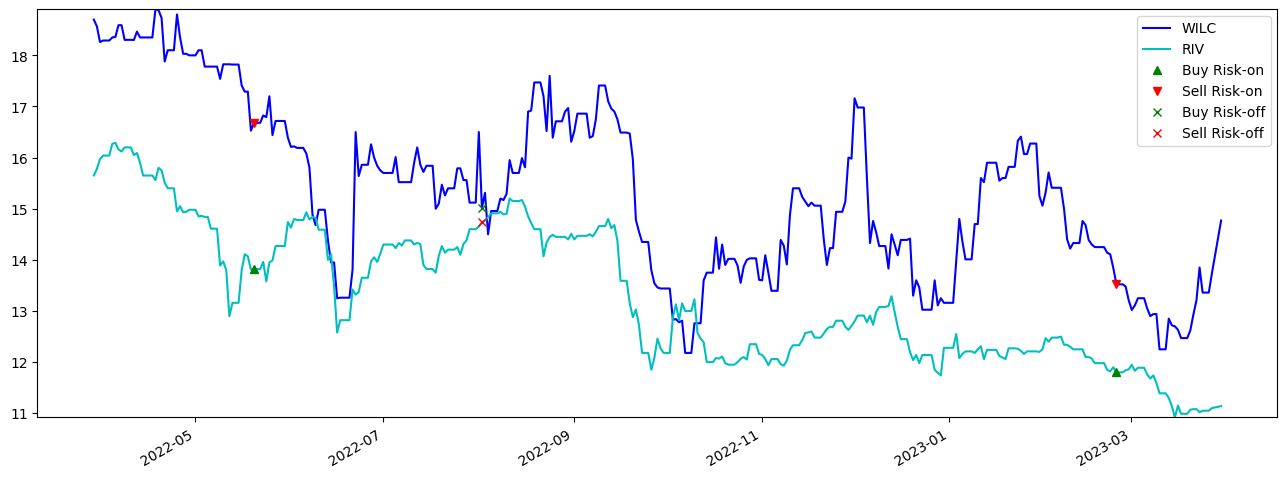

Total reward for this pair: 2.142958752347984
Total return for this pair: 2.142958752347984


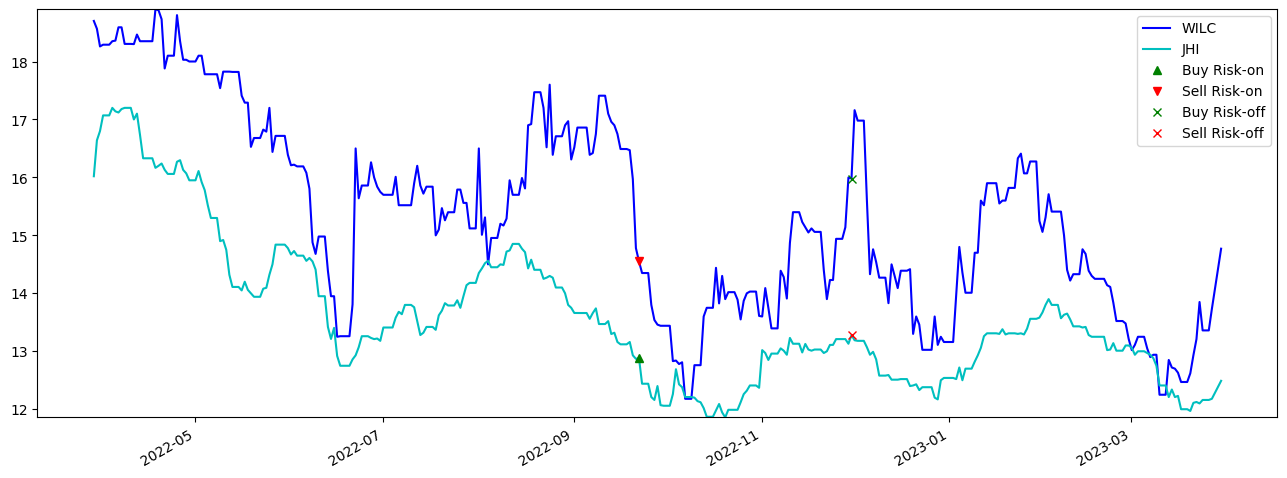

Total reward for this pair: 0.6241937990464785
Total return for this pair: 0.6241937990464785


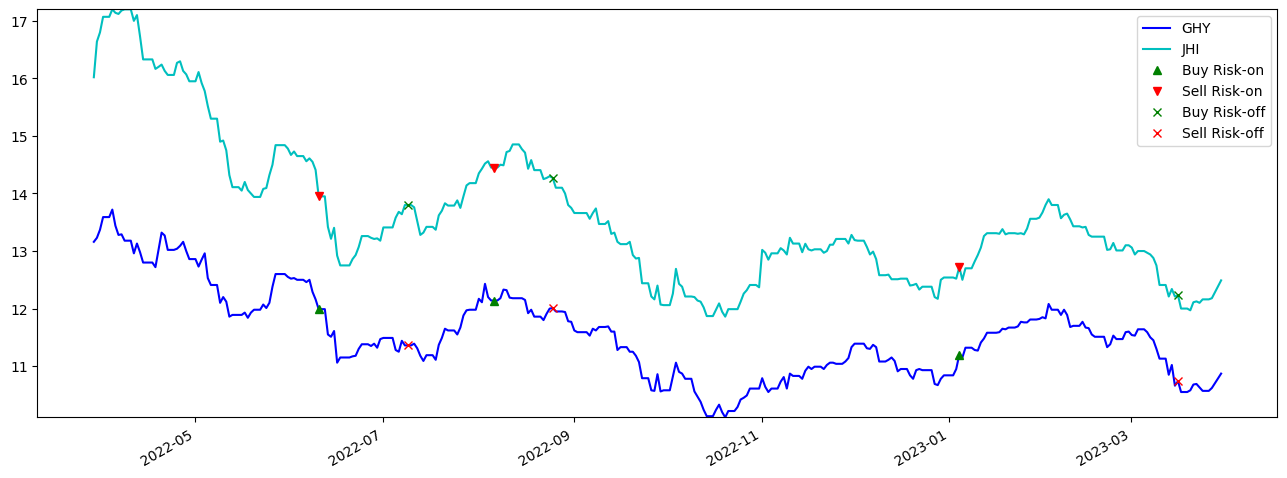

Total reward for this pair: 0.11755364804252087
Total return for this pair: 0.11755364804252087
Average overall rewards: 3.4743856200141265
Average overall returns: 3.530281199262495


In [ ]:
#plot entries/exits on val data
#fill in latest/best model
policy_net.load_state_dict(torch.load('./models/model (117)_80eps_79kset_goodprogress.pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

plot.plotEntryExits(policy_net, target_net, valenvs, device)

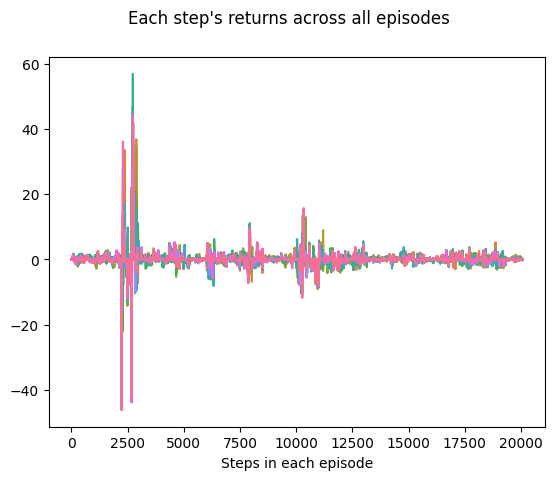

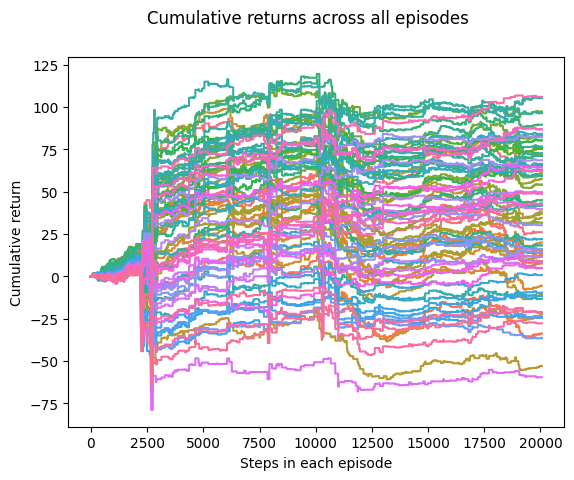

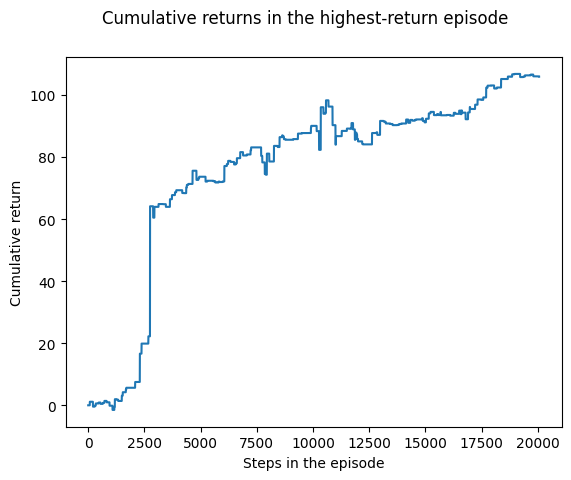

Highest cumulative return in epoch 76, return: 105.90843597787487


In [ ]:
plot.plot_episodes(val_return_dict)

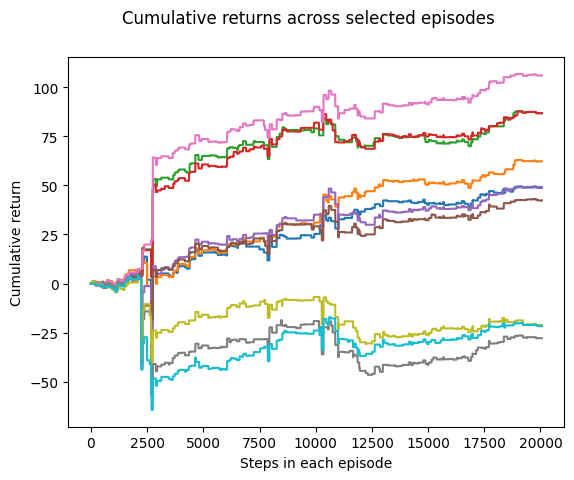

Highest cumulative return in epoch 76, return: 105.90843597787487.


,70,71,72,73,74,75,76,77,78,79
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...
20059,49.130627,62.281583,86.745297,86.830127,48.859149,42.410278,105.908436,-27.816475,-21.167451,-21.72595
20060,49.130627,62.281583,86.745297,86.830127,48.859149,42.410278,105.908436,-27.816475,-21.167451,-21.72595
20061,49.130627,62.281583,86.745297,86.830127,48.859149,42.410278,105.908436,-27.816475,-21.167451,-21.72595
20062,49.130627,62.281583,86.745297,86.830127,48.859149,42.410278,105.908436,-27.816475,-21.167451,-21.72595


In [ ]:
plot.plot_n_episodes(val_return_dict, 70, 80)

# TESTING BEST AGENT ON UNSEEN DATA #

In [ ]:
#revisit how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 344 stocks
cluster 2: 14 stocks
cluster 3: 236 stocks
cluster 5: 66 stocks
cluster 7: 338 stocks
cluster 8: 16 stocks
cluster 9: 75 stocks


In [ ]:
#function to get cluster performance in the testenv of an unseen cluster
def get_cluster_performance(policy_net, target_net, testenvs):
    policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
    target_net.eval()

    total_rewards = []
    total_returns = []
    with torch.no_grad():
        for testenv in testenvs:
            obs = testenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)
                obs, _reward, done, info, _return = testenv.step(Positions(action.item()))
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
                
                if done:
                    total_rewards.append(info['total_reward'])
                    total_returns.append(info['total_return'])
                    break

    cluster_rewards = np.mean(total_rewards)
    cluster_returns = np.mean(total_returns)

    return cluster_rewards, cluster_returns

In [ ]:
#find overall performance on all good and unseen clusters
def unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    overall_rewards = []
    overall_returns = []

    for i in good_clusters_dict.keys():
        #choose cluster of a reasonable size as test cluster
        dailyDF_test = dailyDF[good_clusters_dict[i]]

        #no need to plot heatmap; just to get the testpairs, testpval, testdf,
        testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))
        print(f'Cluster {i} has {len(testpairs)} testpairs.')

        #create testenvs
        testenvs = []
        for testpair in testpairs:
            testdata = testdf[list(testpair)].dropna()
            if testdata.shape[0] > 250:
                #instantiate an env; automatatically run trade()
                testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, transaction_cost))

        #get cluster performance
        cluster_rewards, cluster_returns = get_cluster_performance(policy_net, target_net, testenvs)
        print(f'For cluster {i}, overall reward is {cluster_rewards}, overall return is {cluster_returns}')

        overall_rewards.append(cluster_rewards)
        overall_returns.append(cluster_returns)
    
    print(f'For all clusters, total reward is {np.sum(overall_rewards)}, total return is {np.sum(overall_returns)}.')
    print(f'Average reward is {np.mean(overall_rewards)}, average return is {np.mean(overall_returns)}.')
        

In [ ]:
#Average out all unseen clusters n times
def avg_n_performance(n, good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    avg_n_rewards = []
    avg_n_returns = []

    for e in range(n):

        ep_rewards = []
        ep_returns = []
        
        #loop through each good cluster
        for i in good_clusters_dict.keys():
            dailyDF_test = dailyDF[good_clusters_dict[i]]

            #no need to plot heatmap; just to get the testpairs, testpval, testdf,
            testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))

            #create testenvs
            testenvs = []
            for testpair in testpairs:
                testdata = testdf[list(testpair)].dropna()
                if testdata.shape[0] > 250:
                    #instantiate an env; automatatically run trade()
                    testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, transaction_cost))

            #get cluster performance
            cluster_rewards, cluster_returns = get_cluster_performance(policy_net, target_net, testenvs)
            
            ep_rewards.append(cluster_rewards)
            ep_returns.append(cluster_returns)
        
        avg_n_rewards.append(np.mean(ep_rewards))
        avg_n_returns.append(np.mean(ep_returns))
    
    #Plot all cumulative sums
    sns.lineplot(data=avg_n_rewards, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing average rewards across all clusters')
    plt.xlabel('Iterations')
    plt.ylabel('Average rewards')
    plt.show()

    sns.lineplot(data=avg_n_returns, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing average returns across all clusters')
    plt.xlabel('Iterations')
    plt.ylabel('Average returns')
    plt.show()

    print(f'The average rewards and returns after {n} iterations are respectively {np.mean(avg_n_rewards)} and {np.mean(avg_n_returns)}.')
        

In [ ]:
#One iteration of performance of all clusters
unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)

Cluster 0 has 25 testpairs.
For cluster 0, overall reward is -1.0881874436908199, overall return is -1.0230545770905077
Cluster 2 has 12 testpairs.
For cluster 2, overall reward is 1.1031399356542453, overall return is 1.1031399356542453
Cluster 3 has 34 testpairs.
For cluster 3, overall reward is 1.740279395223151, overall return is 1.8168824493698417
Cluster 5 has 21 testpairs.
For cluster 5, overall reward is 4.109433559171422, overall return is 4.315730886463817
Cluster 7 has 168 testpairs.
For cluster 7, overall reward is -0.07581975928890944, overall return is -0.07369474758380788
Cluster 8 has 12 testpairs.
For cluster 8, overall reward is 2.493391796530348, overall return is 2.6456866278569273
Cluster 9 has 31 testpairs.
For cluster 9, overall reward is -1.4413999386129683, overall return is -1.3462812728850886
For all clusters, total reward is 6.840837544986468, total return is 7.438409301785427.
Average reward is 0.9772625064266383, average return is 1.062629900255061.


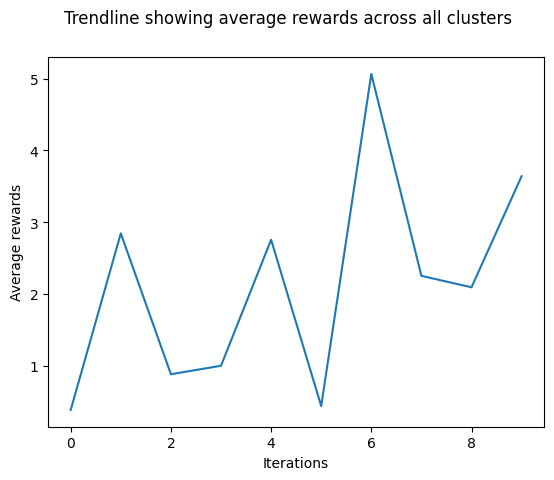

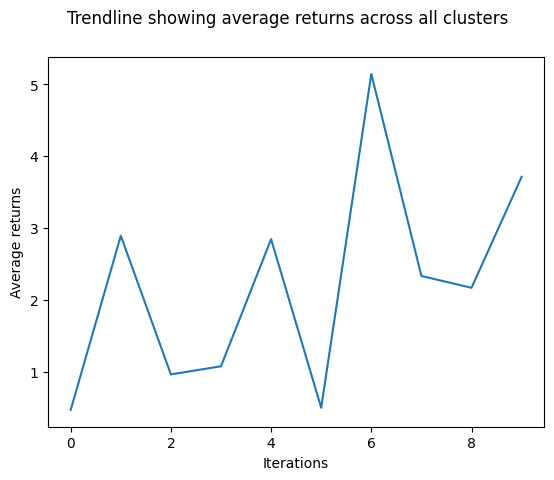

The average rewards and returns after 10 iterations are respectively 2.1347386978827743 and 2.212409104087497.


In [ ]:
#average out the performances of all clusters over total_iter times
total_iter = 10
avg_n_performance(total_iter, good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)